Assignment with L2 Regularization and Xavier Initialization

In [1]:
import sys
sys.path.append("..")
import tqdm_utils
import download_utils

In [2]:
# use the preloaded keras datasets and models
download_utils.link_all_keras_resources()

In [3]:
from __future__ import print_function
import numpy as np
np.random.seed(42)

In [4]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

In [29]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.01, l2_regularization_alpha = None):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        
        # initialize weights with xavier init
        self.weights = np.random.randn(input_units, output_units)*(2/(input_units+output_units))
        self.biases = np.zeros(output_units)
        self.l2_regularization_alpha = l2_regularization_alpha
        
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases
    
    def backward(self,input,grad_output):
        
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output) 
        grad_biases = np.sum(grad_output, axis = 0) 
        
        if self.l2_regularization_alpha:
            grad_weights += 2 * self.l2_regularization_alpha * self.weights
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [30]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        # <your code. Try np.maximum>
        return np.maximum(input, np.zeros(input.shape))
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad


In [31]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [32]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    for layer in network:
        output = layer.forward(input)
        activations.append(output)
        input = output
        
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

In [33]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm_utils.tqdm_notebook_failsafe(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [34]:
def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    
    dense_layers = [dense for dense in network if isinstance(dense,Dense)]
    for dl in dense_layers:
        if dl.l2_regularization_alpha:
            loss += dl.l2_regularization_alpha * np.sum(np.square(dl.weights))
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # <your code: propagate gradients through the network>
    grad_output = loss_grad
    layer_inputs = layer_inputs[:-1]
    for input,layer in zip(layer_inputs[::-1],network[::-1]):
        grad_output = layer.backward(input,grad_output)
        
    return np.mean(loss)

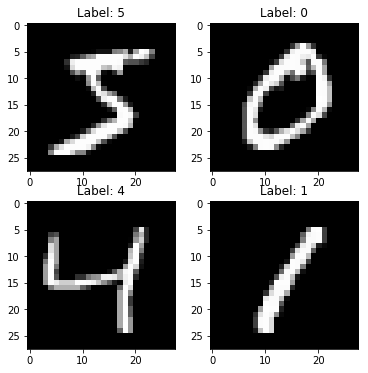

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [36]:
l2_regularization_alpha = 0.001

network = []
network.append(Dense(X_train.shape[1],100, l2_regularization_alpha = l2_regularization_alpha))
network.append(ReLU())
network.append(Dense(100,200, l2_regularization_alpha = l2_regularization_alpha))
network.append(ReLU())
network.append(Dense(200,10, l2_regularization_alpha = l2_regularization_alpha))

In [37]:
from IPython.display import clear_output
train_log_reg = []
val_log_reg = []

In [ ]:
for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log_reg.append(np.mean(predict(network,X_train)==y_train))
    val_log_reg.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log_reg[-1])
    print("Val accuracy:",val_log_reg[-1])
    plt.plot(train_log_reg,label='train accuracy')
    plt.plot(val_log_reg,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()